<a href="https://colab.research.google.com/github/thuyd12/Predict-churners/blob/main/33_Predict_Greenweez_Churners.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 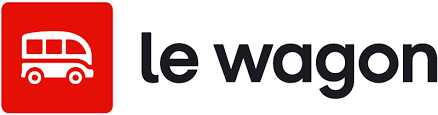

# Predict Greenweez Churners


We want to find who amongst our existing database of clients will reconvert 🔁 (ie. make a second purchase) within 3 months. 

➡️ We have access to the sales from 2019 to 2021.
➡️ Let's take a look at the data


## Data discovery


a) Execute cell below to load data into `df` variable.

In [ ]:
from google.colab import auth
import pandas as pd

# Will collect your credentials
auth.authenticate_user()

# Query Bigquery
query = "SELECT * FROM `data-analytics-bootcamp-363212.course33.gwz_churn`"

df = pd.read_gbq(query, project_id="data-analytics-bootcamp-363212")

b) Let's take a look at our data. 

What do you see? What's the shape of our data? Do you have null values ? What is target ?

In [ ]:
df.shape

(381398, 12)

In [ ]:
df.head()

,date_date,orders_id,customers_id,nb_past_orders,avg_basket,total_purchase_cost,avg_quantity,total_quantity,nb_days_since_last_order,avg_nb_unique_products,total_nb_codes,re_purchase
0,2021-03-08,797405,207754,3,65.456667,196.37,29.333333,88,0,23.000000,1,0
1,2021-06-23,914331,229390,2,84.650000,169.30,40.000000,80,0,34.500000,1,0
2,2021-04-27,857750,4921,3,48.343333,145.03,20.000000,60,0,11.666667,1,1
3,2021-02-28,786589,10797,8,74.970000,599.76,26.500000,212,0,20.750000,8,1
4,2021-06-08,901782,116681,3,62.113333,186.34,16.666667,50,0,9.333333,1,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381398 entries, 0 to 381397
Data columns (total 12 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   date_date                 381398 non-null  dbdate 
 1   orders_id                 381398 non-null  Int64  
 2   customers_id              381398 non-null  Int64  
 3   nb_past_orders            381398 non-null  Int64  
 4   avg_basket                381398 non-null  float64
 5   total_purchase_cost       381398 non-null  float64
 6   avg_quantity              381398 non-null  float64
 7   total_quantity            381398 non-null  Int64  
 8   nb_days_since_last_order  381398 non-null  Int64  
 9   avg_nb_unique_products    381398 non-null  float64
 10  total_nb_codes            381398 non-null  Int64  
 11  re_purchase               381398 non-null  Int64  
dtypes: Int64(7), dbdate(1), float64(4)
memory usage: 37.5 MB


<details>
    <summary><i>Answer:</i></summary>

Your DataFrame should be of shape 381398 * 12.
    
The target is the `re_purchase` column, and the other columns will be your features.
    
There are no null values in data.
</details>        

c) What do you think of column `orders_id` for our problem? Is it useful?

<details>
    <summary><i>Answer:</i></summary>

Orders_id is not useful here as it is a unique identifier in Greenweez database.
</details>   

d) Delete `orders_id` and `date_date` columns.

In [ ]:
df = df.drop(columns = ['date_date', 'orders_id'])

e) Are columns values on different scales? Use DataFrame `.describe()` function to answer.

What kind of preprocessing we will have to use ?

In [ ]:
df.describe()

,customers_id,nb_past_orders,avg_basket,total_purchase_cost,avg_quantity,total_quantity,nb_days_since_last_order,avg_nb_unique_products,total_nb_codes,re_purchase
count,381398.000000,381398.000000,381398.000000,381398.000000,381398.000000,381398.000000,381398.0,381398.000000,381398.000000,381398.000000
mean,161066.560242,2.058692,51.570302,124.525402,13.558555,33.825301,0.0,8.392141,0.544751,0.476864
std,95853.282456,2.030991,41.144718,291.427518,13.202761,71.181359,0.0,7.364444,1.441715,0.499465
min,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.0,1.000000,0.000000,0.000000
25%,69762.000000,1.000000,26.290000,30.310000,5.500000,7.000000,0.0,3.000000,0.000000,0.000000
50%,174880.000000,1.000000,43.760000,65.550000,10.333333,16.000000,0.0,6.500000,0.000000,0.000000
75%,244394.000000,2.000000,66.840000,150.350000,18.000000,38.000000,0.0,11.500000,1.000000,1.000000
max,314334.000000,61.000000,4726.440000,22738.110000,1480.000000,3557.000000,0.0,163.000000,57.000000,1.000000


<details>
    <summary><i>Answer:</i></summary>

Features are indeed on different scales, total_nb_codes in comparison with avg_basket for examples.

We will use a normalization technique.
</details>

f) Set column `customers_id` as index to keep customer_id information.

In [ ]:
df = df.set_index('customers_id')

Note that for the sake of the exercise, we've **already preprocessed some of the data for you** 🔧. 

This means you'll be working on a (relatively) clean database, with your targets and features already formed. In a real-world situation, it's likely that you'll be spending a lot of time forming your target and features from simpler, less-specific data, either using python or SQL to manipulate the database.

## Modeling

Now that we've seen what our data looks like, we need to define our target and features.

a) Split dataset into a train and a test set (this should give you an `X_train`, `X_test`, `y_train` and `y_test`). 

We will keep a test_size of 20%.

In [ ]:
from sklearn.model_selection import train_test_split

# every columns except re_purchase which is our target
X = df.drop(columns='re_purchase')
y = df['re_purchase']

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# store customers_ids for after
test_customers_ids = X_test.index

b) Execute cell below to apply a normalization on data.

We use here a StandardScaler transformation.

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

# apply same transformation on X_test
X_test = scaler.transform(X_test)

c) What is the type of X_train and X_test? Is it expected?

In [ ]:
print(type(X_train))
print(type(X_test))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


<details>
    <summary><i>Answer:</i></summary>

Normalization transforms dataframes to numpy arrays, we will need to cast y_train to int to be able to train our model.
</details>

c) It's now time to use your first classifier model.

We will use a logistic regression model. Execute cell below to train your model on train data and store test data predictions in a variable `y_pred`.

In [ ]:
from sklearn.linear_model import LogisticRegression

# train model
clf = LogisticRegression()
clf.fit(X_train, y_train.astype("int"))

# store predictions
y_pred = clf.predict(X_test)

d) Calculate accuracy you get on train and test data. 

How can you interpret it?

In [ ]:
accuracy_train = clf.score(X_train, y_train.astype("int"))
accuracy_test = clf.score(X_test, y_test.astype("int"))

print(f"{accuracy_train=}")
print(f"{accuracy_test=}")

accuracy_train=0.7315956449635879
accuracy_test=0.7323151546932355


<details>
    <summary><i>Answer:</i></summary>

Logistic regression score corresponds to accuracy. 
We see here 73% accuracy on both train and test data. It means that 73% of our predictions are good.

There is no overfitting as there is no difference in scores between train and test
</details>

e) Accuracy is one way to judge model performance but ploting confusion matrix on test data is a better technique. Because from this matrix you can get plently of metrics !

Execute cell below to plot confusion matrix.

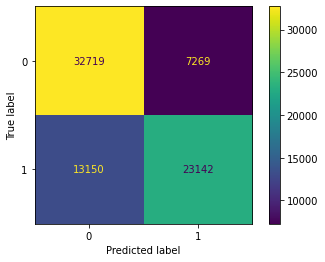

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

confusion_matrix = ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test.astype("int"))

f) From confusion matrix and below picture, calculate:
- precision
- recall
- accuracy

![confusionmetrucs](https://yury-zablotski.netlify.app/post/confusion-matrix/ssw.png)

<details>
    <summary><i>Answer:</i></summary>

- precision: 23142 / (23142 + 7269) = 23142 / 30411 = 75.94%
- recall: 23142 / (13150 + 23142) = 23142 / 36292 = 63.77%
- accuracy: (32719 + 23142) / 76280 = 55861 / 76280 = 73.23%
</details>

g) What is percent of churners your model correctly detected? Is it good? 

<details>
    <summary><i>Answer:</i></summary>

number_churners_correctly_detected / number_of_churners = 32719 / (32719 + 7269) = 32504 / 39988 = 81.82% 

Not bad at all, we have now a model to identify 81.82% of churners :)
</details>

h) Is it better than a stupid model returning always 1?

Obviously, we will have really bad precision and recall metrics.

i) What does this instruction do? How useful it can be from a business perspective?

In [ ]:
proba = pd.DataFrame(clf.predict_proba(X_test), columns=["Churner", "Not churner"], index=test_customers_ids)
proba

,Churner,Not churner
customers_id,,
19015,0.730911,0.269089
251709,0.729279,0.270721
152152,0.431824,0.568176
299297,0.593862,0.406138
32874,0.458414,0.541586
...,...,...
153034,0.669207,0.330793
231272,0.041410,0.958590
235459,0.767621,0.232379


<details>
    <summary><i>Answer:</i></summary>

We can get probability to repurchase or not (column not churner).
</details>

j) Filter on customers who have between 20% and 50% to re purchase.

customers with less than 20% of probability to repurchase are considered as lost.

In [ ]:
proba[(proba["Not churner"] >= 0.2) & (proba["Not churner"] < 0.5)]

,Churner,Not churner
customers_id,,
19015,0.730911,0.269089
251709,0.729279,0.270721
299297,0.593862,0.406138
278985,0.774092,0.225908
203445,0.754141,0.245859
...,...,...
31969,0.719220,0.280780
174029,0.763778,0.236222
153034,0.669207,0.330793


k) Now you have this model. 

Explain which process you suggest to create at greenweez to reduce churn rate?



<details>
    <summary><i>Answer:</i></summary>

On a regular basis, predict churners and send this info back to CRM via ELT process.

CRM team will target those users to send them coupon codes, discounts, ...
to retain them.

This technique is really powerful
</details>